# Introduction
We will implement scratch implementation of three types of ensemble learning. Then check each effect on a smaller dataset.

- Blending
- Bagging
- Stacking

In [38]:
# Predefines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data set prep


## Reg Data

In [39]:
house_price_data = pd.read_csv('../Data/Normal/houseprice_train.csv')
data = house_price_data[['SalePrice','GrLivArea','YearBuilt']]
data.head()

,SalePrice,GrLivArea,YearBuilt
0,208500,1710,2003
1,181500,1262,1976
2,223500,1786,2001
3,140000,1717,1915
4,250000,2198,2000


In [40]:
X = data.drop(columns='SalePrice').to_numpy()
Y = data['SalePrice'].to_numpy()
X.shape, Y.shape

((1460, 2), (1460,))

In [41]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size= 0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1168, 2), (292, 2), (1168,), (292,))

## Classification Data

In [42]:
from sklearn.datasets import load_iris
iris = load_iris()
Xc = X = iris.data[:, :2]
Yc = iris.target
Xc.shape, Yc.shape, 'Class count: ', np.unique(Yc)

((150, 2), (150,), 'Class count: ', array([0, 1, 2]))

In [43]:
xc_train,xc_test,yc_train,yc_test = train_test_split(Xc,Yc, test_size= 0.2)
xc_train.shape,xc_test.shape,yc_train.shape,yc_test.shape

((120, 2), (30, 2), (120,), (30,))

# Problem 1
Blending Scratch Mounting

## Regression Blending


### Model Prototype

In [54]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


from sklearn.model_selection import ParameterGrid
class ModelModule():
    def __init__(self, class_name, param_grid = None):
        self.class_name = class_name
        self.params_list = ParameterGrid(param_grid) if param_grid is not None else None
        # print('ParameterList: ', str(self.params_list))
    def getModels(self):
        if self.params_list is None: return [self.class_name()]
        models = []
        for params in self.params_list:
            models.append(self.class_name(**params))
        return models

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
class ScratchRegBlending():
    def __init__(self, verbose = False):
        self.verbose = verbose
        #Linear reg
        linear_reg_module = ModelModule(LinearRegression) #no hyper for linear_reg
        #SVR
        svr_params = [
            {
                'kernel' : ['linear']
            },
            {
                'kernel' : ['poly'],
                'degree' : [2,3,4],
            },
            {
                'kernel' : ['rbf', 'sigmoid']
            }
        ]
        svr_module = ModelModule(SVR, svr_params)
        #Deci Tree
        tree_params = {
            'criterion' : ['mse', 'mae'],
            'splitter' : ['best', 'random'],
            'max_features' : ['auto', 'sqrt'],
            'max_depth' : [None, 2, 3, 4],
        }
        deci_tree_module = ModelModule(DecisionTreeRegressor, tree_params)

        self.modules = [linear_reg_module, svr_module, deci_tree_module]
        self.models = []
        for module in self.modules:
            self.models.extend(module.getModels())
    def fit(self,X,y,X_val, y_val):
        #prep
        # y = y.reshape(-1,1)
        # if y_val is not None: y_val = y_val.reshape(-1,1)
        #train
        val_result = []
        for model in self.models:
            if self.verbose: print('Fitting model: ', model)
            model.fit(X,y)
        #result
        pred_train = self.predict(X)
        pred_val = self.predict(X_val)
        self.train_score = mean_squared_error(y, pred_train)
        self.val_score = mean_squared_error(y_val, pred_val)
        if self.verbose:
            print('Train MSE: ', self.train_score)
            print('Val MSE: ', self.val_score)
    def predict(self,X):
        result = []
        for model in self.models:
            result.append(model.predict(X))
        # print('Pred result: ', result)
        return np.average(result, axis = 0)



ScratchRegBlending();

### Train Result

In [45]:
np.random.seed(0)
blend_model = ScratchRegBlending(verbose = True)
blend_model.fit(x_train,y_train,x_test,y_test)

Fitting model:  LinearRegression()
Fitting model:  SVR(kernel='linear')
Fitting model:  SVR(degree=2, kernel='poly')
Fitting model:  SVR(kernel='poly')
Fitting model:  SVR(degree=4, kernel='poly')
Fitting model:  SVR()
Fitting model:  SVR(kernel='sigmoid')
Fitting model:  DecisionTreeRegressor(max_features='auto')
Fitting model:  DecisionTreeRegressor(max_features='auto', splitter='random')
Fitting model:  DecisionTreeRegressor(max_features='sqrt')
Fitting model:  DecisionTreeRegressor(max_features='sqrt', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='auto')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='auto', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='sqrt')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='sqrt', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=3, max_features='auto')
Fitting model:  DecisionTreeRegressor(max_depth=3, max_features='auto',

### Compare with base models

In [46]:
blend_train_score,blend_val_score = blend_model.train_score,blend_model.val_score
print('Blend Train: ',blend_train_score)
print('Blend Val: ', blend_val_score)
svr = SVR()
linear = LinearRegression()
deci_tree = DecisionTreeRegressor()
for model in [svr,linear, deci_tree]:
    print(model.__class__.__name__)
    model.fit(x_train,y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_test)
    train_score = mean_squared_error(pred_train, y_train)
    print('Train MSE: ', train_score, 'Compare: ', (train_score - blend_train_score) / blend_train_score * 100 , '%')
    val_score = mean_squared_error(pred_val, y_test)
    print('Val MSE: ', val_score, 'Compare: ', (val_score - blend_val_score) / blend_val_score * 100 , '%')

Blend Train:  1658119113.0761337
Blend Val:  1723697418.5528302
SVR
Train MSE:  6965166765.7537 Compare:  320.0643193137048 %
Val MSE:  5560413794.193806 Compare:  222.58642000300603 %
LinearRegression
Train MSE:  2262517488.4087205 Compare:  36.45084183435472 %
Val MSE:  1868208181.4579213 Compare:  8.383766277634642 %
DecisionTreeRegressor
Train MSE:  17532409.71775114 Compare:  -98.94263267460774 %
Val MSE:  2747521440.6312785 Compare:  59.39696904216654 %


### NOTE: Blend Regression Comparision
- Blend is clearly a 'blending', average of other models
- Blend has better fitting than some models (SVR, Linear) but worse than Tree, Validation is okay compared with SVR and Deci Tree.
- Though, simpler models sometimes perform better under other circumstances (running with different seeds sometimes show that deci tree perform a few % better) due to less overfitting like Linear and DeciTree
- It should also be pointed out that current test only uses 2 dimensions for prediction so the fit in all models are horrible, so there's no definitive winner here.

## Blend Classification

In [47]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
class ScratchClsBlending:
    def __init__(self,verbose = False):
        self.verbose = verbose
        models = []
        models.append(('LR', 
                  LogisticRegression(solver ='lbfgs', 
                                     multi_class ='multinomial', 
                                     max_iter = 200)))
        models.append(('SVC', SVC(gamma ='auto', probability = True)))
        models.append(('DTC', DecisionTreeClassifier()))
        self.model = VotingClassifier(estimators = models, voting = 'soft') #soft: average probabilty 
    def fit(self,X,y,X_val = None,y_val = None):
        self.model.fit(X,y)
        if self.verbose:
            train_pred = self.predict(X)
            val_pred = self.predict(X_val)
            self.train_score = accuracy_score(y,train_pred)
            if y_val is not None:
                self.val_score = accuracy_score(y_val, val_pred)
                print('Train Acc: ', self.train_score)
                print('Val Acc: ', self.val_score)
    def predict(self,X):
        return self.model.predict(X)

In [48]:
blend_cls_model = ScratchClsBlending(verbose= True)
blend_cls_model.fit(xc_train,yc_train,xc_test,yc_test)

Train Acc:  0.9333333333333333
Val Acc:  0.8


### Compare

In [49]:
blend_cls = ScratchClsBlending()
svc = SVC()
logis = LogisticRegression(max_iter=1000)
deci = DecisionTreeClassifier()
for model in [blend_cls,svc,logis, deci]:
    print(model.__class__.__name__)
    model.fit(xc_train,yc_train)
    pred_train = model.predict(xc_train)
    pred_val = model.predict(xc_test)
    train_score = accuracy_score(pred_train, yc_train)
    print('Train Acc: ', train_score)
    val_score = accuracy_score(pred_val, yc_test)
    print('Val Acc: ', val_score)

ScratchClsBlending
Train Acc:  0.925
Val Acc:  0.8333333333333334
SVC
Train Acc:  0.7583333333333333
Val Acc:  0.9
LogisticRegression
Train Acc:  0.775
Val Acc:  0.9333333333333333
DecisionTreeClassifier
Train Acc:  0.9416666666666667
Val Acc:  0.7666666666666667


### NOTE: Compare blend cls with base
Slight improve in validation accuracy compared to others in some cases! Fitting is also better 

In [50]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,x_test = None, y_test = None, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue','orange']
    contourf_color =  ['pink', 'skyblue', 'navajowhite']
    n_class = 3

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label='Train: '+ target_names[i], marker='o', alpha = 0.3)
    if not x_test is None:
        for i,target in enumerate(set(y_test)):
            plt.scatter(x_test[y_test==target][:, 0], x_test[y_test==target][:, 1], s=10, color=scatter_color[i], label= 'Test: ' +target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

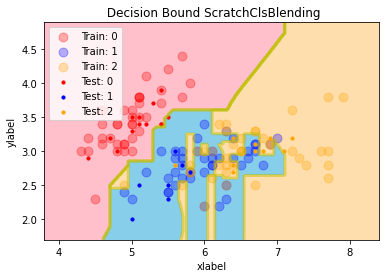

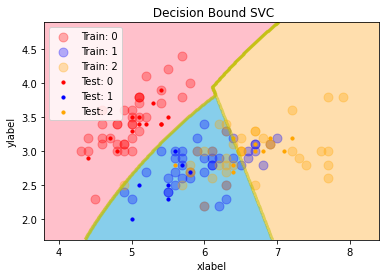

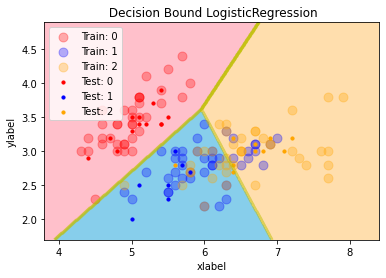

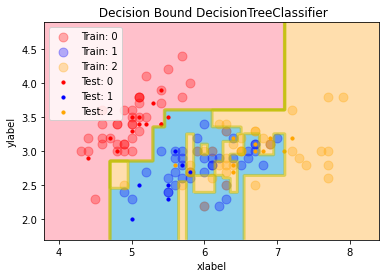

In [51]:
for model in [blend_cls,svc,logis, deci]:
    decision_region(xc_train,yc_train,model, x_test = xc_test, y_test = yc_test, title = ' Decision Bound ' + model.__class__.__name__, target_names= ['0','1','2'])

### NOTE: deciboundary blend cls
Though, looking at the decision boundary, it could be seen that overfitting in te blend cls modelis happening cause the deciboundary has very weird particular shape. The slight increase in validation accuracy does not make up for this overfiting boundary! (my opinion)

# Problem 2
Sratch Mounting of Bagging

## Bagging Prototype

In [101]:
from sklearn.base import clone
class ScratchBaggingModel():
    def __init__(self, model, max_iter = 100, subset_size = 0.2, verbose = False, mode = 'Regression'):
        self.mode = mode
        self.verbose = verbose
        self.model = model
        self.iter = max_iter
        self.subset_size = subset_size
    def fit(self,X,y,X_val = None, y_val = None):
        if self.mode == 'Classification':
            self.labels = np.sort(np.unique(y))
        split_seeds = np.arange(self.iter)
        self.models = []
        for i in range(self.iter):
            model = clone(self.model)
            Xi,_,yi,_ = train_test_split(X,y, train_size= self.subset_size, random_state = split_seeds[i])
            model.fit(Xi,yi)
            self.models.append(model)
        if self.mode == 'Regression':
            self.train_score = mean_squared_error(y, self.predict(X))
            if y_val is not None:
                self.val_score = mean_squared_error(y_val, self.predict(X_val))
        else:
            self.train_score = accuracy_score(y, self.predict(X))
            if y_val is not None:
                self.val_score = accuracy_score(y_val, self.predict(X_val))
    def predict(self,X):
        if self.mode == 'Regression':
            result = []
            for model in self.models:
                result.append(model.predict(X))
            return np.average(result, axis = 0)
        else: #classification
            proba_result = []
            for model in self.models:
                proba_result.append(model.predict_proba(X))
            proba_result = np.average(proba_result, axis = 0)
            # print('proba_result: ', proba_result.shape)
            pred_label = np.zeros(len(X))
            for i in range(len(X)):
                # print(i,proba_result[i], np.argmax(proba_result[i]))
                pred_label[i] = self.labels[np.argmax(proba_result[i])]
            return pred_label


Train, test Acc:  0.85 0.8666666666666667


## Compare with blending

In [84]:
#bag model
bag_reg_model = ScratchBaggingModel(DecisionTreeClassifier())
bag_reg_model.fit(x_train,y_train,x_test,y_test)
bagging_train_err,bagging_val_err = bag_reg_model.train_score, bag_reg_model.val_score
print('Bagging Train err: ', bagging_train_err, 'Bagging val err: ', bagging_val_err)

#blend model
blend_model = ScratchRegBlending()
blend_model.fit(x_train,y_train,x_test,y_test)
blend_train_err,blend_val_err = blend_model.train_score, blend_model.val_score
print('Blend Train err: ', blend_train_err, 'Blend val err: ', blend_val_err)

#compare
print('Bagging has more train error of: ', (bagging_train_err - blend_train_err) / blend_train_err * 100, '%')
print('Bagging has more val error of: ', (bagging_val_err - blend_val_err) / blend_val_err * 100, '%')



Bagging Train err:  1249604976.6441133 Bagging val err:  1339887338.4186778
Blend Train err:  1627030609.2229388 Blend val err:  1741262400.3521085
Bagging has more train error of:  -23.19720541453624 %
Bagging has more val error of:  -23.05080853134294 %


### NOTE: comparision
- Can be seen that bagging is much more proficient compared to blendin in both training and validation. This must be due to it mechanic of averaging different subset (aspect) of the data which leads to better fitting but also better generalization!
- It's also the fact that i choose DeciTree as the base model for bagging which usually fit very well to data set!

## Bagging Classification?

Train, test Acc:  0.85 0.8666666666666667


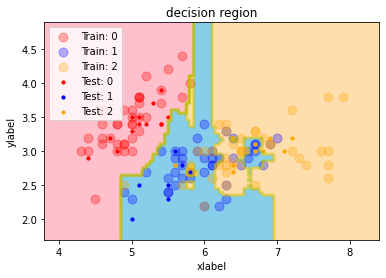

In [105]:
bag_cls = ScratchBaggingModel(DecisionTreeClassifier(), mode = "Classification")
bag_cls.fit(xc_train,yc_train,xc_test,yc_test)
print('Train, test Acc: ', bag_cls.train_score, bag_cls.val_score)

decision_region(xc_train,yc_train,bag_cls,x_test= xc_test,y_test = yc_test, target_names= ['0','1','2'])

### NOTE: cls bagging compare with others
Can be seen that the cls bagging strategy does not have a very high accuracy. In my opinion, this comes from this main factor:
- The cls dataset (iris) is too small, it does not fit with our strat of training on subset. If the subsets are too small, it does not give us insight from different aspects of the dataset but instead a wrong angle and misinformation.

Though, bagging cls does have promising result due to it's generalization power!

# Problem 3
Stacking